# Random number generators
Physical or True RNGs assign a number of bits $b$ based on a random event $E$ and a decision rule $\delta(E)\rightarrow\{0,1\}^b$; This involves asking the question, *what is the probability that event $E$ will have happened by the end of an observation window time of length $t_w$*.

## Random times

QRNGs based on photon detection in particular measure functions of arrival times and counts. Random events in time $\tau$ follow the [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution), and counts of independent random events over a period of time follow the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution), with [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function)

$\begin{align*}
\mathcal{E}(t_w, \lambda) & = 1-e^{-\lambda t_w}\\
\mathcal{P}(t_w, \lambda,k) & = e^{-\lambda t_w}\sum _{i=0}^{\lfloor k\rfloor }{\frac {(\lambda t_w) ^{i}}{i!}}\ 
\end{align*}$

Note that these measure quite different events: the former measures the probability that a random time $\tau \leq t_w$, which tends to $1$ as the frequency of counts increases; while the latter measures the probability that the number of events counted $N_{t_w} \leq k$, which tends to $0$ as the frequency of counts increases.

In [9]:
import numpy

# observation window length
tw = 2.5*1e-7

# number of data points
numDots = 100

# frequency of photon detections
# if more than one detector per randel, this is the base frequency
# and other detectors in the randel are a function of this
lambda_0 = numpy.logspace(5, 8, numDots)	 #numpy.arange(10**5,10**8,10**5)

lambda_tw = lambda_0 * tw 
numWindows = 1/tw

cumulative = 1-numpy.exp(-lambda_0*tw)
survival = 1-cumulative

def PoissPMF(k):
    
    return numpy.exp(-lambda_tw)*lambda_tw**k/numpy.math.factorial(k)

def PoissCDF(k):
    
    s = numpy.zeros(numDots)
    for j in range(0,k+1):
        s = s + lambda_tw**j/numpy.math.factorial(j)
    return numpy.exp(-lambda_tw)*s

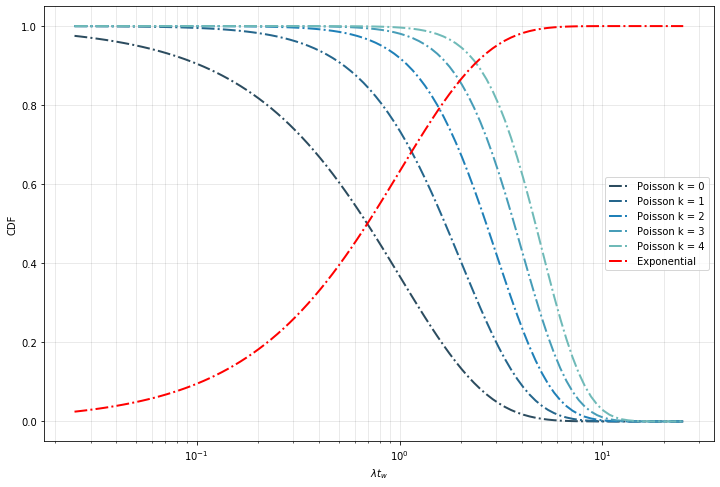

In [10]:
# optional cell to plot the CDF

import matplotlib.pyplot as pplt
import seaborn

inchX = 12
inchY = 8
linewidth_model = 2

fig1 = pplt.figure()
fig1.set_size_inches(inchX, inchY, forward=True)
ax1 = fig1.gca()

ax1.set_xlabel(r'$\lambda t_w$')
ax1.set_ylabel(r'CDF')

K = 5
ygbd = seaborn.color_palette('YlGnBu_d', n_colors=K)
#yord = seaborn.color_palette('YlOrRd_d', n_colors=K)

for i in range(K):
    labl = r'Poisson k = {0}'.format(i)

    ax1.semilogx(lambda_tw, PoissCDF(i), linewidth=linewidth_model, linestyle='-.', color=ygbd[i], label=labl )
ax1.semilogx(lambda_tw, cumulative, linewidth=linewidth_model, linestyle='-.', color='red', label='Exponential' )
    
lg1 = ax1.legend(loc=0, frameon=True)

ax1.patch.set_facecolor('w')
ax1.grid(True, color='black', alpha=.1, which='both', linestyle='-')

## Entropy
The *randomness* or *uncertainty* of the output is measured as **entropy**. The most common measures are [Shannon entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory))

$H _{1}(X)\equiv \lim _{\alpha \to 1}H_{\alpha }(X)=-\sum _{i=1}^{n}p_{i}\log p_{i}$,

and [min-entropy](https://en.wikipedia.org/wiki/Min-entropy)

$H_{\infty }(X)\doteq \min _{i}(-\log p_{i})=-(\max _{i}\log p_{i})=-\log \max _{i}p_{i}$.

Min-entropy is considered especially important for security applications as it measures the worst-case uncertainty produced by each output, so it gives a security practitioner a little more confidence in forcing an adversary to do a minimum amount of work to explore the space of all possible outputs.

For reference, there is also a function called [Rényi entropy](https://en.wikipedia.org/wiki/R%C3%A9nyi_entropy) that generalizes special cases.

In [11]:
def H_Shannon(pmf):
    return -numpy.sum(pmf*numpy.log2(pmf), axis=0)

def H_min(pmf):
    return numpy.nanmin(-numpy.log2(pmf), axis=0)

## SPAD-based QRNG comparison

We begin by considering the ideal scenario for each generation method, disregarding non-idealities of the instrumentation such as detector dead-time, afterpulsing, crosstalk etc. While these are often significant factors in choosing one practical implementation over another, we describe the ideal case first.

### Complement
Perhaps the simplest design, used e.g. in [Burri et al.](https://infoscience.epfl.ch/record/191217?ln=en), involves a single-SPAD randel generating one bit with a decision rule of whether a photon detection has occurred in $t_w$ or not:

$\begin{align}
    \delta(\tau) & = \begin{cases}1\quad \tau \leq t_w \\ 0 \quad \mbox{o/w}\end{cases} \\
    \mathbb{P}(\delta(\tau)=1) & = \mathcal{E}(t_w, \lambda)
\end{align}$

The advantage of this is that it uses the complementary event as a source of entropy: even if there is no detection, one can still generate output.

This involves tuning the incident light so that the frequency of photon detection by the SPAD is as close to 50% as possible.

### Oversampling

The oversampling technique is based on the observation that the lower the frequency of events per unit time, the more uniformly the few recorded events are distributed within that time. In practice, the clock frequency of the sampler - a time-to-digital converter (TDC) - is much higher than the frequency of the signal, i.e. the photon detections.

We model a TDC with $b$ bits as a mapping from a continuous interval to a binary representation $\Delta: [0,t_w) \rightarrow \{0,1\}^b$. Under ideal conditions of a perfect clock, we assume the window is covered by $2^b-1$ time sub-intervals of equal length $t_b=t_w/(2^b-1)$, with one of the possible output codes being reserved for 'no arrival'. In practie, the TDC will be initialized to some value, say $0$, and will not start unless there is a detection; or it will always be initialized, say to $2^b-1$, always start counting down and only stop if there is a detection, in which case a readout $0$ still corresponds to no detection.

Regardless of the mapping induced by $\Delta$, the distribution of the first arrival time $\tau$ will be exponential. Assuming for simplicity that the TDC always counts up from $0$ and stops at a recorded time, the probability mass function of the discretized random variable $\Delta(\tau)$ for the $n-th$ bin will be


$\begin{align}
    \mathbb{P}(\tau\in[(n-1)t_b, nt_b)) & = \mathcal{E}(\lambda,nt_b)-\mathcal{E}(\lambda, (n-1)t_b) \\
    \Delta(\tau \in [(n-1)t_b, nt_b)) & = n-1 \\
    \delta(\tau) & = \begin{cases}\Delta(\tau) \quad \tau \leq t_w \\ \varnothing \quad \mbox{o/w}\end{cases} \\
\end{align}$

### Conditional-1

As noted and implemented in [Bisadi et al.](http://nanolab.physics.unitn.it/index.php/publications-online-docs/journal-articles/2017/453-robust-quantum-random-number-generation-with-silicon-nanocrystals-light-source), the distribution of arrival times in $[0,t_w)$ *conditional on there being a single arrival* is uniform. In practice, this involves measuring arrival times and discarding all data when more than one detection was registered in the time interval. Windows with no arrival also generate no data.

$\begin{align}
    \mathbb{P}(\tau\leq t | N_{t_w}=1) & = t/t_w \\
    \delta(\tau) & = \begin{cases}\Delta(\tau) \quad \tau \leq t_w \cap N_{t_w}=1 \\ \varnothing \quad \mbox{o/w}\end{cases}  \\
\end{align}$

This is similar to oversampling but requires additionally discarding results from windows with more than one detection, so trading off bitrate in exchange for a theoretically perfect output.

### Spatial difference

Given any two independent and identically distributed (i.i.d.) continuous random variables $A,B$, $\mathbb{P}(A\leq B) = 1/2$. If we compare two arrival times from two adjacent SPADs under equal illumination with the decision rule

$\begin{align}
    \delta(\tau_A, \tau_B) = \begin{cases}1\quad \tau_A \leq \tau_B \\ 0 \quad \tau_A \geq \tau_B\end{cases}
\end{align}$

these should be uniform random variables regardless of any change in the slope of the distribution of individual arrival times.

Here we note that SPAD are never identical but have a mismatch, so even if the incident illumination is perfectly uniform over the area of both SPAD, their detection frequencies will be different. Additionally, there will be dark counts not due to the light source, as well as crosstalk events and a bias due to the arbiter circuit comparing the two arrival times.

The architecture implemented in [Tomasi et al.](https://dx.doi.org/10.1109/JLT.2018.2829210) combines the spatial difference and complement approach: it is capable of comparing two events at adjacent SPAD, or one event and an empty window.

### Temporal difference

As spatial difference, comparing two arrival times at the same SPAD in different windows. This eliminates the bias due to SPAD detection efficiency mismatch, but may introduce bias due to afterpulsing and decay of the stored analogue time value.

The architecture implemented in [Xu et al.](https://doi.org/10.1016/j.vlsi.2018.05.009) is capable of comparing two events in time at the same SPAD (time difference) or one event and an empty window.

In [17]:
def Burri():
    
    p_zeros = survival
    p_ones = cumulative

    bitrate = numWindows*numpy.ones(numDots)
    entropy_per_bit = H_Shannon(numpy.stack((p_zeros, p_ones)))
    min_per_bit = H_min(numpy.stack((p_zeros, p_ones)))
    entropy_per_second = bitrate * entropy_per_bit
    min_per_second = bitrate * min_per_bit
    return (entropy_per_second, min_per_second)

def oversampling(TDC_bits):
    numBins = (2**TDC_bits)-1
    entropy_oversampling = numpy.zeros(len(lambda_0))
    min_oversampling = numpy.zeros(len(lambda_0))
    
    t_b = float(tw) / numBins
    n = numpy.arange(1,numBins+1,1)
    
    for f in range(len(lambda_0)):
        l = lambda_0[f]    
        pmf = (1-numpy.exp(-n*l*t_b)) - (1-numpy.exp(-(n-1)*l*t_b))
        pmf = pmf/numpy.sum(pmf)
        entropy_oversampling[f] = H_Shannon(pmf)
        min_oversampling[f] = H_min(pmf)

    entropy_per_second = entropy_oversampling*cumulative*numWindows
    min_per_second = min_oversampling*cumulative*numWindows
    return (entropy_per_second, min_per_second)

def Bisadi(TDC_bits):

    entropy_per_second = TDC_bits*PoissPMF(1)*numWindows
    return entropy_per_second
    
def spatial_difference(mismatch, offset, crosstalk):
    
    m=mismatch
    lambda_1 = m*lambda_0
    lambda_plus = lambda_0+lambda_1
    tp = offset
    Sp0 = numpy.exp(-lambda_0*tp)
    Sp1 = numpy.exp(-lambda_1*tp)
    pc = crosstalk

    p = lambda_0*Sp1*(1-pc)/lambda_plus
    #p1 = lambda_1*Sp0*(1-pc)/lambda_plus
    q = 1-p		
    H = H_Shannon([p,q])#-p*numpy.log2(p) -q*numpy.log2(q)
    Hmin = H_min([p,q])
    prob_empty = survival**2
    entropy_per_second = (1-prob_empty)*H*numWindows
    min_per_second = (1-prob_empty)*Hmin*numWindows
    
    return (entropy_per_second, min_per_second)
    
def Hps(labl, H):
    
    if H == 'Shannon':
        switch = 0
    elif H == 'min':
        switch = 1
        
    if labl == 'complement':

        return Burri()[switch]

    elif labl == 'oversampling, 8 bits':
        
        return oversampling(8)[switch]
        
    elif labl == 'oversampling, 1 bit':
        
        return oversampling(1)[switch]
        
    elif labl == 'spatial difference with complement':

        return spatial_difference(1.1, 1e-10, .05)[switch]
    
    elif labl == 'conditional-1, 8 bits':

        return Bisadi(8)
    
    elif labl == 'conditional-1, 1 bit':

        return Bisadi(1)

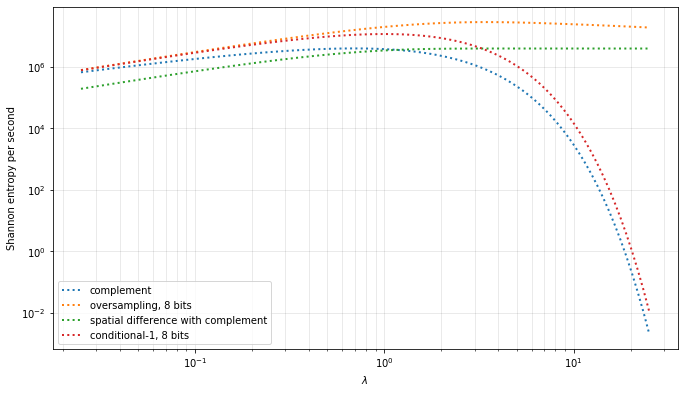

In [18]:
import matplotlib.pyplot as pplt
import seaborn

# list of items to be plotted
item = [
        'complement', 
        'oversampling, 8 bits', 
        #'oversampling, 1 bit', 
        'spatial difference with complement',
        'conditional-1, 8 bits',
        #'conditional-1, 1 bit'
       ]

numItems = len(item)
helix = seaborn.cubehelix_palette(numItems, start=1.8, rot=-1.25)
pairs = seaborn.color_palette("tab20")

scale = .7
inchX = 16*scale
inchY = 9*scale
linewidth_model = 2

# Shannon entropy

fig2 = pplt.figure()
fig2.set_size_inches(inchX, inchY, forward=True)
ax2 = fig2.gca()

ax2.set_xlabel(r'$\lambda$')
ax2.set_ylabel(r'Shannon entropy per second')

for i in range(numItems):
    labl = item[i]
    ax2.loglog(lambda_tw, Hps(labl,'Shannon'), linewidth=linewidth_model, linestyle=':', color=pairs[2*i], label=labl )

lg2 = ax2.legend(loc=0, frameon=True)

ax2.patch.set_facecolor('w')
ax2.grid(True, color='black', alpha=.1, which='both', linestyle='-')


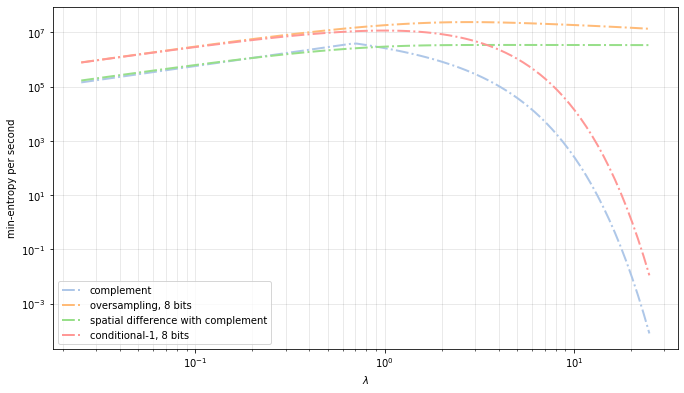

In [19]:
# min-entropy

fig3 = pplt.figure()
fig3.set_size_inches(inchX, inchY, forward=True)
ax3 = fig3.gca()

ax3.set_xlabel(r'$\lambda$')
ax3.set_ylabel(r'min-entropy per second')

for i in range(numItems):
    labl = item[i]
    ax3.loglog(lambda_tw, Hps(labl, 'min'), linewidth=linewidth_model, linestyle='-.', color=pairs[2*i+1], label=labl )

lg3 = ax3.legend(loc=0, frameon=True)

ax3.patch.set_facecolor('w')
ax3.grid(True, color='black', alpha=.1, which='both', linestyle='-')


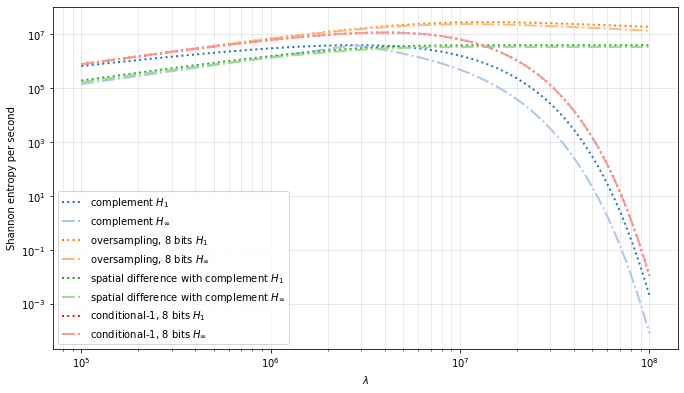

In [20]:
# combined entropy graph

fig4 = pplt.figure()
fig4.set_size_inches(inchX, inchY, forward=True)
ax4 = fig4.gca()

ax4.set_xlabel(r'$\lambda$')
ax4.set_ylabel(r'Shannon entropy per second')

for i in range(numItems):
    labl = item[i]
    ax4.loglog(lambda_0, Hps(labl,'Shannon'), linewidth=linewidth_model, linestyle=':', color=pairs[2*i], label=labl+' $H_{1}$' )
    ax4.loglog(lambda_0, Hps(labl, 'min'), linewidth=linewidth_model, linestyle='-.', color=pairs[2*i+1], label=labl+' $H_{\infty}$' )

lg4 = ax4.legend(loc=0, frameon=True)

ax4.patch.set_facecolor('w')
ax4.grid(True, color='black', alpha=.1, which='both', linestyle='-')


## Notation
$\lambda$ - photon detections per second

$t_w$ - window of time (seconds)

$\mathcal{E}(t_w, \lambda)$ - cumulative distribution function, exponential

$\mathcal{P}(t_w, \lambda, k)$ - cumulative distribution function, Poisson


# Theme
You can run the following cell to change the appearance of this notebook to suit your taste. Check for available themes on [github.com/dunovank/jupyter-themes](https://github.com/dunovank/jupyter-themes).

In [16]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('chesterish')